# Task 1: Simulating Fisher-Wright

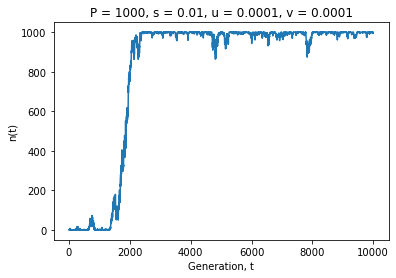

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

rng = np.random.default_rng()

def psm(n, P, s, u, v):
    """We heavily reuse this"""
    ps = (1+s)*n/(P+n*s)
    return (1-v)*ps + u*(1-ps)

def updateFW(n, P, s, u, v):
    """Generate a new population of size P starting with n individuals of type B"""
    return rng.binomial(P, psm(n, P, s, u, v))

class FisherWright():
    """Simulate the Dynamics of the Fisher-Wright Model
    We create an iterator to this"""
    
    def __init__(self, param):
        "create a function with the parameter set apart form n"
        self.update = partial(updateFW, **param)
        
    def __iter__(self):
        n = self.n0
        #this is just for lazy evaluation, I think?
        yield n
        while True:
            n = self.update(n)
            yield n

    def __call__(self, n0):
        """initiate n0 and return iterator"""
        self.n0 = n0
        return iter(self)

param = {"P": 1000, "s": 0.01, "u": 0.0001, "v": 0.0001}

fisherWright = FisherWright(param)

T = 10000

#returns a tuple list of data points of the generation number and the value of n(t)
def evolution(model, n0, T, transform=lambda x: x):
    """Run the model for T generations starting from n0
        transform the output of the model with default of doing nothing"""
    it = model(n0)                # create a new iterator
    return [(i, transform(next(it))) for i in range(T)]

#Wrap the code to show the results of the fisher wright evolution into a resusable function
def show_FW(data_points):
    
    def dict_to_str(dic):
        return ", ".join([f"{key} = {value}" for (key,value) in param.items()])

    plt.plot(*zip(*data_points))        # weird trick to get matplotlib to plot a list of (x,y) pairs
    plt.xlabel("Generation, t")
    plt.ylabel("n(t)")
    plt.title(dict_to_str(param))
    plt.show()

#A list of tuples the model produces
data_points = evolution(fisherWright, 0, T)
show_FW(data_points)

## Task 1 Questions

1. Under what conditions does trait B take over the population

Trait B takes over the population if there is a balance in the forward/backward mutation rates u and v such that v is below a certain amount and u is large enough  meaning the forward7 mutations outweigh the backward mutatoins, provided the population is a sufficiently large size.

2. Take-over time investigations depending on various factors

First we need to define a function that calculates in what number generation trait B has taken over the population, we simply iterate through the populations generated by the model keeping a count of what generation we are on and return the number generation where the proportion of B traited individuals is >= 0.95:

In [2]:
def calc_takeover_time(param_dict):
    
    model = FisherWright(param_dict)
    
    #lets take the initial generation number to always be 0
    for gen_num, val in enumerate(model(0)):
        
        if(val >= 0.95 * param_dict['P']):
            return gen_num

2a. Investigate how different values of the selection strength (s) affects takeover time:

In [3]:
def investigate_s_dependance():
    
    #the s value will be timesed by 10 on each iteration
    params = {'P': 10000, 's': 0.0001, 'u': 0.0001, 'v': 0.0001}
    
    #tuples of the s value paired with the takeover time
    data_points = []
    
    for i in range(800):
        
        #record the value of s and the takeover time
        data_points.append((params['s'], calc_takeover_time(params)))
        #params['s'] *= 10
        params['s'] += 0.0001
    
    plt.plot(*zip(*data_points))
    plt.xlabel("Selection strength (s), linear scale")
    plt.ylabel("Takeover time, log scale")
    plt.yscale("log")
    #plt.xscale("log")
    plt.title("How takover time varies depending on t s values")
    plt.show()

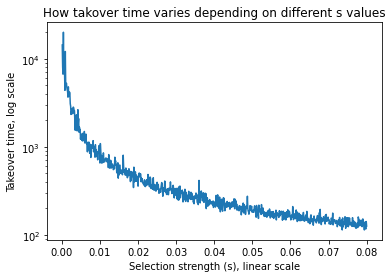

In [30]:
investigate_s_dependance()

We can see that there is a steady correlation between selection strength and takeover time: as selection strength increases, takeover time decreases; however, as selection strength increases the rate at which takeover time decreases slows down.

2b. Investigate how different values of mutation (such that forwards mutation and backwards mutation variables are the values we change on each iteration but they are always equal to each other) affects takeover time:

In [133]:
def investigate_mut_dependance():
    
    #the u and v vals will be incremented by 0.00001 on each iteration
    params = {'P': 10000, 's': 0.01, 'u': 0.00001, 'v': 0.00001}
    
    #tuples of the m value paired with the takeover time
    data_points = []
    
    for i in range(155):
                
        #u and v will always be the same so just pick either
        data_points.append((params['u'], calc_takeover_time(params)))
        params['u'] += 0.00001
        params['v'] += 0.00001
    
    plt.plot(*zip(*data_points))
    plt.xlabel("Mutation rate (m), linear scale")
    plt.ylabel("Takeover time, log scale")
    plt.yscale("log")
    plt.title("How takover time varies depending on the mutation rate")
    plt.show()
    #return data_points

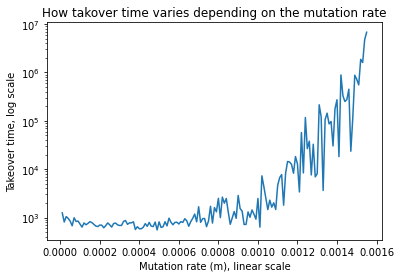

In [134]:
data_points = investigate_mut_dependance()

### Mutation rate effect on takeover time observation

Changing the mutation rate had a very interesting effect on the population, and if you think about it it makes sense. On each iteration we are keeping both the forward AND backward mutation rates the same meaning they will sort of cancel one another out; in fact, when investigating over a certain number of iterations (around 160, which is why I have kept it at 155, each iteration increments the mutation rate by 0.00001 where the mutation rate on the initial iteration is also 0.00001, hence on iteration 155 the values of u and v are both 0.00156) I found that the algorithm never even finished (or took much longer than my computer could handle) as clearly the rate of an individual in the population mutating to the other trait (either an A individual mutating to a B individual or a B individual mutating to an A individual) became so large that a sort of "equilibrium" state is reached in the population and it becomes extremely unlikely for one trait to take over the population due to huge numbers of both B individuals and A individuals appearing in subsequent generations. I believe the data on the graph supports my hypothesis due to the fluctuating, but increasing takeover time through subsequent generations.

2c. Investigate how changing the population size P affects takeover time:

In [25]:
def investigate_P_dependance():
    
    #the P value will be timesed by 10 on each iteration
    params = {'P': 100, 's': 0.01, 'u': 0.0001, 'v': 0.0001}
    
    #tuples of the P value paired with the takeover time
    data_points = []
    
    for i in range(15):
        
        #u and v will always be the same so just pick either
        data_points.append((params['P'], calc_takeover_time(params)))
        params['P'] *= 10
    
    plt.plot(*zip(*data_points))
    plt.xlabel("Population size (P), log scale")
    plt.ylabel("Takeover time, linear scale")
    #plt.yscale("log")
    plt.xscale("log")
    plt.title("How takover time varies depending on the population size")
    plt.show()

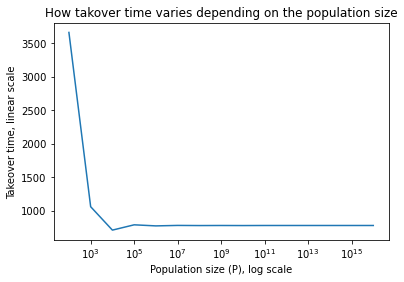

In [26]:
investigate_P_dependance()

A larger population size causes a quicker takeover time of trait B, however only up to a certain threshold, a population larger than around 100,000 has little effect on decreasing the takeover time as you can see in the graph

# Task 2: Multiple runs

In [4]:
#assume a model is something that when run, returns a list of tuples
#where the first element of each tuple is the generation number
#and the second element is some value
def multiple_runs(model, n_runs):

    runs = []
    for i in range(n_runs):
        runs.append(list(model()))
        
    average = []
    for i in range(len(runs[0])):
        #use np.mean with a list generator to find the average of all elements in the same "column"
        average.append((i, np.mean([runs[j][i][1] for j in range(n_runs)])))
    
    return average

length of runs[0] is: 10000

THE RESULTS OF A SINGLE FISHER-WRIGHT MODEL RUN:


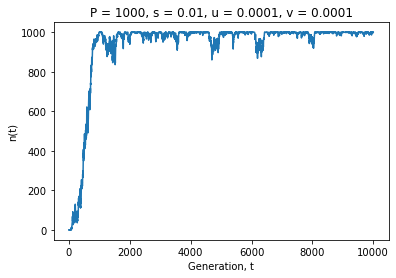


THE AVERAGE OF 1000 FISHER-WRIGHT MODEL RUNS:


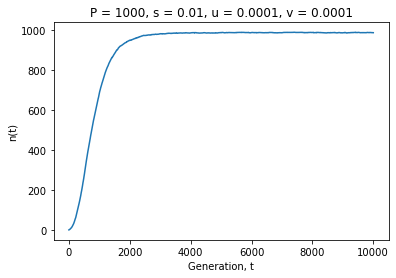

In [98]:
#let's take the average of say 1000 runs, passing in our model as a callable
average_runs = multiple_runs(lambda: evolution(fisherWright, 0, T), 1000)
single_run = evolution(fisherWright, 0, T)
print("\nTHE RESULTS OF A SINGLE FISHER-WRIGHT MODEL RUN:")
show_FW(single_run)
print("\nTHE AVERAGE OF 1000 FISHER-WRIGHT MODEL RUNS:")
show_FW(average_runs)

# Task 3: Markov model

In [5]:
from scipy.stats import binom
import math

def transition_matrix(P, s, u, v):
    n = np.arange(0,P+1)
    p = psm(n,P,s,u,v)
    return np.array([binom.pmf(nn, P, p) for nn in n])

W = transition_matrix(**param)

In [6]:
column0 = sum(W[i][0] for i in range(len(W)))

## 1. Show that columns all sum to 1

If the sum of column sums is the same as the number of columns, then the sum of each must be 1:

In [7]:
def prove_columns_sum_to_1(matrix):
    n_cols = len(matrix)
    colSum = 0
    for i in range(len(matrix[0])):
        colSum += sum(matrix[j][i] for j in range(len(matrix)))
    return (n_cols, int(colSum))

In [8]:
#Round the result to an integer as the result is the same except
#floats are slightly inaccurate
n_cols, colSum = prove_columns_sum_to_1(W)
print("The number of columns were", n_cols)
print("And the sum of all column sums is", colSum)

The number of columns were 1001
And the sum of all column sums is 1001


## 2. Check for different parameters

Write a function that tries random combinations of parameteres and ensures the columns of each all still adds to 1. If any matrix has columns that don't sum to 1 then the function prints this:

In [13]:
def check_different_params():
    
    #Try 100 random configurations of parameters
    for i in range(100):
        
        #base the parameter ranges from the upper bounds of my
        #investigations into takeover time up above. Use smaller
        #population range as my computer cant handle many large populations
        s = np.random.random() * 0.1
        P = int(np.random.random() * (10 ** 4))
        v = np.random.random() * 0.0015
        u = np.random.random() * 0.0015
        print("The parameters are:")
        print(s, P, v, u)
        
        matrix = transition_matrix(P,s,u,v)
        n_cols, colSum = prove_columns_sum_to_1(matrix)
        if(n_cols != colSum):
            print("Found a matrix with columns that don't sum to 1!")
            break
    
    print("Success, didn't come across a matrix with any columns not summing to 1")

In [14]:
check_different_params()

The parameters are:
0.005918942426638485 8020 7.27502369135839e-05 0.0007886442284719984
The parameters are:
0.05937743560808542 9857 0.0014426927082222037 0.00024554514531983457
Found a matrix with columns that don't sum to 1!
Success, didn't come across a matrix with any columns not summing to 1


In [28]:
def dict_to_str(dct):
    string = "{"
    for (key,val) in dct.items():
        string += str(key) + " : " + str(val) + ","
    string += "}"
    return string

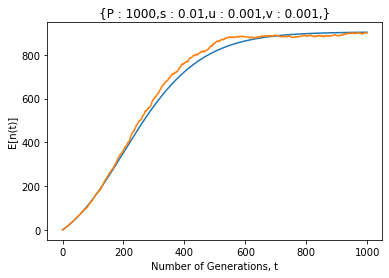

In [29]:
no_runs = 100

class MarkovChain():
    """Markov Chain Model for simulating the Fisher Wright Model"""
    
    def __init__(self, P, s, u, v):
        self.W = transition_matrix(P, s, u, v)
        self.n = range(P+1)
        self.P = P
        
    def __iter__(self):
        p = np.array(self.p0)
        yield p
        while True:
            p = self.W@p
            yield p
            
    def mean(self, p):
        return self.n@p
    
    def __call__(self, n):
        self.p0 = np.zeros(self.P+1)
        self.p0[n] = 1
        return iter(self)

T = 1000

param = {"P": 1000, "s": 0.01, "u": 0.001, "v": 0.001} # Speed up mutation

fisherWright = FisherWright(param)


markovChain = MarkovChain(**param)
evoMarkov = evolution(markovChain, 0, T, markovChain.mean)

multievo = evolution(fisherWright, np.zeros(no_runs), T, np.mean)

plt.plot(*zip(*evoMarkov), *zip(*multievo))
plt.xlabel("Number of Generations, t")
plt.ylabel("E[n(t)]")
plt.title(dict_to_str(param))
plt.show()

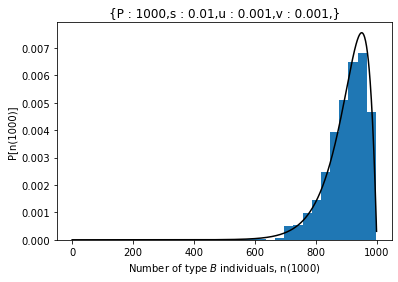

In [30]:
def distribution(model, n0, T):
    """Return the distribution of the Population After T iterations starting from n0"""
    it = model(n0)
    for _ in range(T-1):
        next(it)
    dist = next(it)
    return list(range(len(dist))), dist


# Use markovChain model
n, markovDist = distribution(markovChain, 0, T)

# Simulate 1000 runs
no_copies = 1000
_, multiDist = distribution(fisherWright, np.zeros(no_copies), T)

plt.hist(multiDist, 20, density=True)
plt.plot(n, markovDist, "k")
plt.xlabel(f"Number of type $B$ individuals, n({T})")
plt.ylabel(f"P[n({T})]")
plt.title(dict_to_str(param))
plt.show()
 

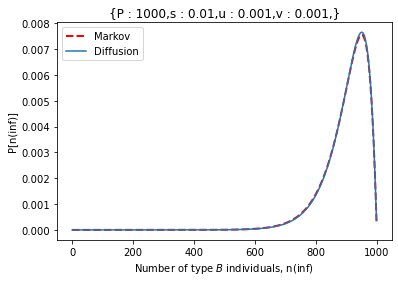

In [31]:
## Diffusion Approximation

class steadyStateDiffusion():
    """ Computes the diffusion approximation to the steady state"""
    
    def __init__(self, P, s, u, v):
        self.param = [P,s,u,v]
        self.P = P
        self.norm = 1
        self.norm, _ = scipy.integrate.quad(self.__call__, 0, P)
        self.norm *= 1

    def psm(self, x):
        _, s, u, v = self.param
        ps = (1+s)*x/(1+s*x)
        return ps*(1-v) + u*(1-ps)

    def integrand(self, x):
        p = self.psm(x)
        a = p-x
        bs = p*(1-p)/self.P
        return -2*a/bs

    def __call__(self, n):
        x = n/self.P
        p = self.psm(x)
        bs = p*(1-p)/self.P
        integral, _ = scipy.integrate.quad(self.integrand,x,0.5)
        return math.exp(integral)/(self.norm*bs)

param = {"P": 1000, "s": 0.01, "u": 0.001, "v": 0.001} # Speed up mutation

diffusion = steadyStateDiffusion(**param)

## Markov Solution after a long time
T= 1000
n, markovDist = distribution(markovChain, 0, T)

#fig = plt.figure(figsize=(12,8))
plt.plot(n, markovDist, "--r", linewidth=2, label="Markov")

diffResult = [diffusion(i) for i in n]

plt.plot(n, diffResult, label="Diffusion")

plt.xlabel("Number of type $B$ individuals, n(inf)")
plt.ylabel("P[n(inf)]")
plt.title(dict_to_str(param))
plt.legend()
plt.show()

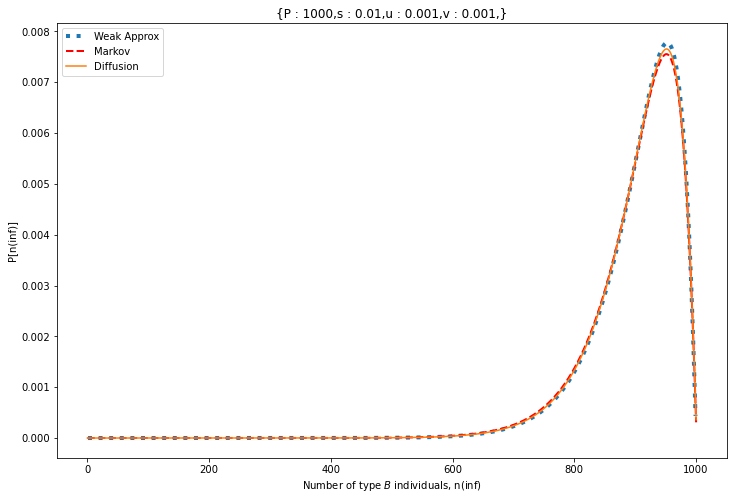

In [32]:
class steadyStateWeakApprox():
    """Computes the steady state using the approximation of weak mutation and selection"""
    
    def __init__(self, P, s, u, v):
        self.abc = 2*P*np.array([u, v, s])
        self.P = P
        a, b, c = self.abc
        self.norm = -math.log(P) - scipy.special.betaln(a,b) - math.log(scipy.special.hyp1f1(a, a+b, c))
        
    def __call__(self, n):
        x = n/self.P
        a, b, c = self.abc
        return np.exp((a-1)*np.log(x) + (b-1)*np.log(1-x) + c*x + self.norm)



fig = plt.figure(figsize=(12,8))  # Make the graph bigger

# Compute distribution using the weak selection/mutation approximation
weakApprox = steadyStateWeakApprox(**param)
nouter = np.array(n[1:-1])    # ignore x=0 and x=1 as logarithms don't like this
plt.plot(nouter, weakApprox(nouter), ":", linewidth=4, label="Weak Approx")


# Plot Markov result
plt.plot(n, markovDist, "r--", linewidth=2, label="Markov")

# Plot the diffusion approximation result
plt.plot(n, diffResult, label="Diffusion")

plt.xlabel("Number of type $B$ individuals, n(inf)")
plt.ylabel("P[n(inf)]")
plt.title(dict_to_str(param))
plt.legend()
plt.show()

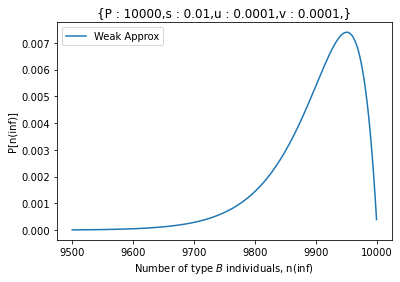

In [33]:
param = {"P": 10000, "s": 0.01, "u": 0.0001, "v": 0.0001}
weakApprox = steadyStateWeakApprox(**param)
n = np.linspace(param["P"]-500,param["P"]-1, 200)
plt.plot(n, weakApprox(n), label="Weak Approx")

plt.xlabel("Number of type $B$ individuals, n(inf)")
plt.ylabel("P[n(inf)]")
plt.title(dict_to_str(param))
plt.legend()
plt.show()

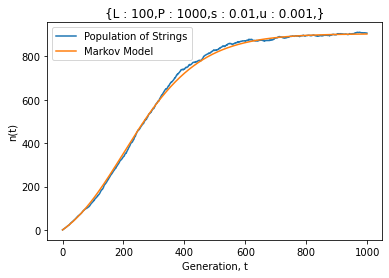

In [34]:
from bisect import bisect

class Population():
    """Container of Population"""
    
    def __init__(self, P, L):
        """create P genomes of length L initialised to 0 string"""
        self.pop = np.zeros((P,L), dtype=bool)
        self.P = P
        self.L = L
        
    def __getitem__(self, k):
        """return genome of individual k"""
        return self.pop[k,:]
    
    def __len__(self):
        """size of population"""
        return self.P
    
    def no_ones(self):
        """compute the number of 1's in each string"""
        return np.sum(self.pop, axis=1)
    
    def prob(self, s):
        """Compute the probability of seclecting each member"""
        F = self.no_ones()
        F -= max(F)            # prevent overflow
        w = pow(1.0+s, F)
        return w/sum(w)
    
    def choose_parents(self, n, s):
        """Choose n parents according to their fitness"""
        p = self.prob(s)
        cp = np.cumsum(p)
        r = np.random.rand(2*self.P)
        return [bisect(cp, rng.random()) for _ in range(n)]
    
    def crossover(self, m, f):
        """Create a child by choosing each allele from either parent with equal probability"""
        mask = np.random.randint(2,size=self.L)
        imask = 1 - mask
        return mask*self[f] + imask*self[m] 
        
    def recombine(self, s):
        """Generate a new population from 2 P parents selected according to their fitness"""
        n = self.choose_parents(2*self.P, s)
        newPop = Population(self.P, self.L)
        for m,f,c in zip(n[::2], n[1::2], range(self.P)):
            newPop.pop[c,:] = self.crossover(f,m)
        return newPop
    
    def selection(self, s):
        """Generate a new population asexually"""
        n = self.choose_parents(self.P, s)
        newPop = Population(self.P, self.L)
        for c, p in enumerate(n):
            newPop.pop[c,:] = self[p]
        return newPop
        
    def mutate(self, u):
        """Flip spins with probablity u
        It does this by drawing a random deviate representing the expected gap between mutations"""
        PL = self.P*self.L
        c = 1.0/math.log(1.0-u)
        flat = self.pop.view(dtype=bool).reshape(PL)
        s = int(c*math.log(np.random.rand()))
        while s < PL:
            flat[s] = 1-flat[s]
            s += int(c*math.log(np.random.rand()))
            
    def mutants_per_site(self):
        """We are interested in the frequency of mutations at each Site"""
        return np.sum(self.pop, axis=0)

    def __str__(self):
        """Create a nice sting showing the population of their fitness"""
        F = self.no_ones()
        s = ""
        for k in range(self.P):
            s += f"{k}: {1*self[k]} F={F[k]}\n"
        return s

class PopulationEvol():
    """Iterate Class to Evolve a Population"""
    
    def __init__(self, L, P, s, u):
        self.L = L
        self.P = P
        self.s = s
        self.u = u
        
    def __iter__(self):
        pop = Population(self.P, self.L)
        yield pop
        while True:
            pop = pop.recombine(self.s)
            pop.mutate(self.u)
            yield pop
            
    def __call__(self, dummy):
        return iter(self)
    
def meanFitness(pop):
    """Returns the mean number of mutations in the population"""
    return np.mean(pop.mutants_per_site())

# Run a Population of strings
paramGA = {"L": 100, "P": 1000, "s": 0.01, "u": 0.001}
modelGA = PopulationEvol(**paramGA)
T = 1000
evoGA = evolution(modelGA, None, T, meanFitness)

# Compare with Marov Model
param = {"P": 1000, "s": 0.01, "u": 0.001, "v": 0.001}
markovChain = MarkovChain(**param)
evoMarkov = evolution(markovChain, 0, T, markovChain.mean)

plt.plot(*zip(*evoGA), label="Population of Strings")
plt.plot(*zip(*evoMarkov), label="Markov Model")
plt.xlabel("Generation, t")
plt.ylabel("n(t)")
plt.title(dict_to_str(paramGA))
plt.legend()
plt.show()

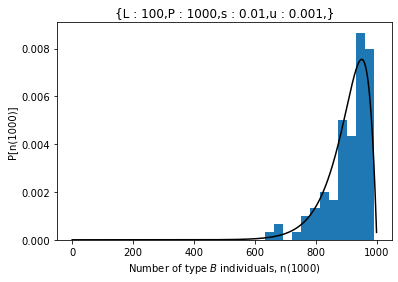

In [35]:
# Distribution in Population

n, markovDist = distribution(markovChain, 0, T)
modelGA = PopulationEvol(**paramGA)
_, gaDist = distribution(modelGA, 0, T)

plt.hist(gaDist.mutants_per_site(), 12, density=True)
plt.plot(n, markovDist, "k")
plt.xlabel(f"Number of type $B$ individuals, n({T})")
plt.ylabel(f"P[n({T})]")
plt.title(dict_to_str(paramGA))
plt.show()
 

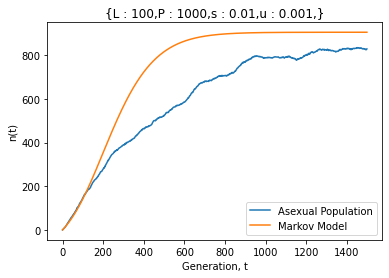

In [36]:
class PopulationAsexualEvol():
    """Iterate Class to Evolve a Population"""
    
    def __init__(self, L, P, s, u):
        self.L = L
        self.P = P
        self.s = s
        self.u = u
        
    def __iter__(self):
        pop = Population(self.P, self.L)
        yield pop
        while True:
            pop = pop.selection(self.s)
            pop.mutate(self.u)
            yield pop
            
    def __call__(self, dummy):
        return iter(self)

# Run a Population of strings
paramGA = {"L": 100, "P": 1000, "s": 0.01, "u": 0.001}
modelGAa = PopulationAsexualEvol(**paramGA)
T = 1500
evoGAa = evolution(modelGAa, None, T, meanFitness)

# Compare with Marov Model
param = {"P": 1000, "s": 0.01, "u": 0.001, "v": 0.001}
markovChain = MarkovChain(**param)
evoMarkov = evolution(markovChain, 0, T, markovChain.mean)

plt.plot(*zip(*evoGAa), label="Asexual Population")
plt.plot(*zip(*evoMarkov), label="Markov Model")
plt.xlabel("Generation, t")
plt.ylabel("n(t)")
plt.title(dict_to_str(paramGA))
plt.legend()
plt.show()